In [2]:
import random
import warnings
import argparse
import shutil
import scipy as sp

import torch
import torch.backends.cudnn as cudnn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import clip

In [10]:
def get_text_features(clip_model, template, class_names, device):
    with torch.no_grad():
        texts = torch.cat(
            [clip.tokenize(template.format(c.replace("_", " ")))
            for c in class_names]).to(device)
        text_features = clip_model.encode_text(texts)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

In [12]:
clip_model, _ = clip.load("ViT-B/16", "cuda")
classifier = clip_model.visual
# clip.model.convert_weights(classifier)
classifier.load_state_dict(torch.load("./exp0/checkpoints/best-PACS.pth"))
classifier.eval()
print("Loaded classifier")

Loaded classifier


In [13]:
class_names = ["Dog", "Elephant", "Giraffe", "Guitar", "Horse", "House", "Person"]
text_features = get_text_features(clip_model, "a photo of a {}.", class_names, "cuda")

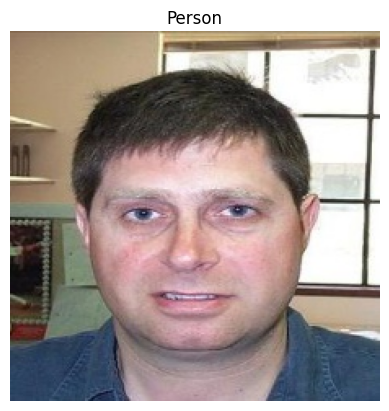

In [23]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

image_origin = Image.open("test_data/1.jpg")

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
image=transform(image_origin).unsqueeze(0).to("cuda")
# compute output
image_features = classifier(image)
image_features /= image_features.norm(dim=-1, keepdim=True)

# measure accuracy and record loss
output_similarity = image_features @ text_features.T
predicted_index = output_similarity.argmax()
# Display the image
plt.imshow(image_origin)
plt.axis('off')
plt.title(class_names[predicted_index])
plt.show()